# Electricity demand in Quebec

We now focus on electricity consumption in Quebec.



## Hydro-Québec open data

Since 2019, Hydro-Québec shares data on various aspects regarding its operations, at the page https://www.hydroquebec.com/documents-data/open-data/.

Here, we are interested in the historical demand: https://www.hydroquebec.com/documents-data/open-data/history-electricity-demand-quebec/. In particular, we can track the hourly total demand in Quebec, noting that
> Electricity demand for one hour corresponds to the total average demand during that hour.

> The data is determined at the end of a time period. For example, the average hourly demand associated with 2019‑01‑01 2:00 is the average of the data collected from 2019‑01‑01 1:05 to 2019‑01‑01 2:00.

We will analyze the data using Pandas and Plotly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## A first forecasting model

The model we will built is highly simplified as the total Quebec consumption is taken into account, along with a single weather station.

In [2]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from data.get_data import HQ_data
from statsmodels.tsa.arima.model import ARIMA

class Fourier_series:

    def get_predictions(self, data, train_start, train_end, test):

        pf = PolynomialFeatures(degree=2)

        data = data.loc[train_start:test, :].copy()

        # get fourier series features
        ff_week = self.get_fourier_features(5, 7, data.loc[:, "day"])
        ff_24h = self.get_fourier_features(5, 24, data.loc[:, "hour"])
        fourier_features = pd.concat([ff_week, ff_24h], ignore_index=True, axis=1)

        # add extra predictors
        features = ["scaled_temp", "temp_lag_15", "temp_index_15", 
                    "demand_lag_24", "is_clear", "rel_hum", "scaled_temp_diff_24", "scaled_temp_diff_48"]

        X = fourier_features
        X[features] = data.loc[:, features]
        X.columns = X.columns.astype(str)
        
        # train model

        X_train = pf.fit_transform(X.loc[train_start:train_end, :])
        y_train = data.loc[train_start:train_end, "log_demand"]

        model = sm.OLS(y_train, X_train).fit()

        # get forecast
        X_test = pf.fit_transform(np.array(X.loc[test, :]).reshape(1, -1))
        forecast  = np.exp(model.predict(X_test))

        return forecast
    

    def get_fourier_features(self, n_order, period, values):
        fourier_features = pd.DataFrame(
            {
                f"fourier_{func}_order_{order}_{period}": getattr(np, func)(
                    2 * order * np.pi * values / period
                )
                for order in range(1, n_order + 1)
                for func in ("sin", "cos")
            }
        )
        return fourier_features

In [3]:
from data.get_data import HQ_data
from models.regression_splines import SplineRegression
# from models.fourier_series import Fourier_series
from models.arma import ARMA_model
from models.mlp import MLP_model

class Simulation:

    def __init__(self, num_iters, train_start, train_end):

        self.num_iters = num_iters
        self.train_start = train_start
        self.train_end = train_end
        self.test = self.train_end + datetime.timedelta(days=1)
        self.data = HQ_data()
        self.data = self.data.get_history()

    def get_prediction(self, train_start, train_end, test):

        """ 
        Implement algorithm or call model here. 
        Model should have get_predictions method that takes in data, train_start, train_end, test 
        and returns a single forecast for the time step test: 24 hour after train_end

        """

        """mlp = MLP_model()
        forecasts = mlp.get_predictions(self.data, train_start, train_end, test)"""

        """spline_reg = SplineRegression()
        forecasts = spline_reg.get_predictions(self.data, train_start, train_end, test)"""

        fourier = Fourier_series()
        forecasts = fourier.get_predictions(self.data, train_start, train_end, test)

        """arma = ARMA_model()
        forecasts = arma.get_predictions(self.data, train_start, train_end, test)"""

        return forecasts

    def run_simulation(self):
        
        train_start = self.train_start
        train_end = self.train_end
        test = self.test

        forecasts = []

        for i in range(self.num_iters):

            forecast = self.get_prediction(train_start, train_end, test)
            forecasts.append(forecast)

            print("********************************************")
            print("At iteration "+ str(i))
            print("forecast: ", forecast)
            print("********************************************")

            # We increment the various times by one hour.
            train_start = train_start + datetime.timedelta(hours=1)
            train_end = train_end + datetime.timedelta(hours=1)
            test = test + datetime.timedelta(hours=1)

        return np.array(forecasts).flatten()

    def plot_sim_results(self, forecasts):

        sim_start = self.train_end + datetime.timedelta(days=1)
        sim_end = sim_start + datetime.timedelta(hours = self.num_iters) - datetime.timedelta(hours=1)

        results = self.data.loc[sim_start:sim_end, ["demand", "scaled_temp"]]
        results["forecast"] = forecasts

        # save forecasts to csv
        results.to_csv("results\\results_fourier_2021.csv")

        residuals = results.loc[:, "demand"] - results.loc[:, "forecast"]

        print("RMSE")
        print(np.sqrt(np.mean(residuals**2)))

        print("MAPE")
        print(np.mean(abs(residuals)/results.loc[:, "demand"]))

        print("Percentage within 1000 mwh")
        print(sum(list(map(lambda x: int(x <= 1000), abs(residuals))))/len(residuals))

        print("Percentage within 500 mwh")
        print(sum(list(map(lambda x: int(x <= 500), abs(residuals))))/len(residuals))

        plt.plot(results.loc[:, "demand"], label="Demand")
        plt.plot(results.loc[:, "forecast"], label="Forecast")
        plt.legend()
        plt.title("24 hour ahead energy demand forecast for year 2022")
        plt.show()

ModuleNotFoundError: No module named 'models'

C:\Users\slash\OneDrive - Universite de Montreal\Conf\2024\JOPT\data\get_data.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="backfill", inplace=True)


********************************************
At iteration 0
forecast:  [24308.32163319]
********************************************
********************************************
At iteration 1
forecast:  [23914.71817937]
********************************************
********************************************
At iteration 2
forecast:  [24001.50472954]
********************************************
********************************************
At iteration 3
forecast:  [23788.76108948]
********************************************
********************************************
At iteration 4
forecast:  [23696.21408466]
********************************************
********************************************
At iteration 5
forecast:  [23741.65623848]
********************************************
********************************************
At iteration 6
forecast:  [23925.6031761]
********************************************
********************************************
At iteration 7
forecast: 

********************************************
At iteration 62
forecast:  [27456.52180608]
********************************************
********************************************
At iteration 63
forecast:  [26996.98813987]
********************************************
********************************************
At iteration 64
forecast:  [26808.093769]
********************************************
********************************************
At iteration 65
forecast:  [27313.28330152]
********************************************
********************************************
At iteration 66
forecast:  [28354.88621443]
********************************************
********************************************
At iteration 67
forecast:  [29290.49693821]
********************************************
********************************************
At iteration 68
forecast:  [29109.71162371]
********************************************
********************************************
At iteration 69
for

********************************************
At iteration 124
forecast:  [24864.04216904]
********************************************
********************************************
At iteration 125
forecast:  [25034.19421117]
********************************************
********************************************
At iteration 126
forecast:  [25748.14274893]
********************************************
********************************************
At iteration 127
forecast:  [27491.45943179]
********************************************
********************************************
At iteration 128
forecast:  [29357.37357345]
********************************************
********************************************
At iteration 129
forecast:  [31357.92497656]
********************************************
********************************************
At iteration 130
forecast:  [29525.40553638]
********************************************
********************************************
At iterati

********************************************
At iteration 185
forecast:  [24538.78089633]
********************************************
********************************************
At iteration 186
forecast:  [26113.28147134]
********************************************
********************************************
At iteration 187
forecast:  [27819.88881918]
********************************************
********************************************
At iteration 188
forecast:  [29584.56738853]
********************************************
********************************************
At iteration 189
forecast:  [27820.08803295]
********************************************
********************************************
At iteration 190
forecast:  [27568.48478252]
********************************************
********************************************
At iteration 191
forecast:  [27508.82028299]
********************************************
********************************************
At iterati

********************************************
At iteration 246
forecast:  [23775.12232623]
********************************************
********************************************
At iteration 247
forecast:  [24738.07145508]
********************************************
********************************************
At iteration 248
forecast:  [26664.07260251]
********************************************
********************************************
At iteration 249
forecast:  [28138.13367347]
********************************************
********************************************
At iteration 250
forecast:  [28026.29331243]
********************************************
********************************************
At iteration 251
forecast:  [27380.35443442]
********************************************
********************************************
At iteration 252
forecast:  [26930.49488896]
********************************************
********************************************
At iterati

********************************************
At iteration 307
forecast:  [27454.62428935]
********************************************
********************************************
At iteration 308
forecast:  [27168.5006935]
********************************************
********************************************
At iteration 309
forecast:  [26535.51699358]
********************************************
********************************************
At iteration 310
forecast:  [25921.96410306]
********************************************
********************************************
At iteration 311
forecast:  [25013.1910865]
********************************************
********************************************
At iteration 312
forecast:  [23809.13572472]
********************************************
********************************************
At iteration 313
forecast:  [22888.3603956]
********************************************
********************************************
At iteration 

********************************************
At iteration 368
forecast:  [23123.04745006]
********************************************
********************************************
At iteration 369
forecast:  [24120.794358]
********************************************
********************************************
At iteration 370
forecast:  [24803.47713823]
********************************************
********************************************
At iteration 371
forecast:  [25354.56894442]
********************************************
********************************************
At iteration 372
forecast:  [25675.97519308]
********************************************
********************************************
At iteration 373
forecast:  [25777.0030887]
********************************************
********************************************
At iteration 374
forecast:  [25810.76193801]
********************************************
********************************************
At iteration 

********************************************
At iteration 429
forecast:  [31747.97744655]
********************************************
********************************************
At iteration 430
forecast:  [30762.05317186]
********************************************
********************************************
At iteration 431
forecast:  [30425.47067096]
********************************************
********************************************
At iteration 432
forecast:  [29416.45407986]
********************************************
********************************************
At iteration 433
forecast:  [28090.15047811]
********************************************
********************************************
At iteration 434
forecast:  [27598.96820209]
********************************************
********************************************
At iteration 435
forecast:  [27927.65485079]
********************************************
********************************************
At iterati

********************************************
At iteration 490
forecast:  [30705.06031519]
********************************************
********************************************
At iteration 491
forecast:  [29764.79494079]
********************************************
********************************************
At iteration 492
forecast:  [29053.93860553]
********************************************
********************************************
At iteration 493
forecast:  [28638.04568683]
********************************************
********************************************
At iteration 494
forecast:  [28713.46082315]
********************************************
********************************************
At iteration 495
forecast:  [28374.07884808]
********************************************
********************************************
At iteration 496
forecast:  [28267.87419628]
********************************************
********************************************
At iterati

********************************************
At iteration 551
forecast:  [31661.19408693]
********************************************
********************************************
At iteration 552
forecast:  [30726.09061105]
********************************************
********************************************
At iteration 553
forecast:  [29858.75702456]
********************************************
********************************************
At iteration 554
forecast:  [29098.64514671]
********************************************
********************************************
At iteration 555
forecast:  [29194.61111719]
********************************************
********************************************
At iteration 556
forecast:  [29493.20457986]
********************************************
********************************************
At iteration 557
forecast:  [29943.92803424]
********************************************
********************************************
At iterati

********************************************
At iteration 612
forecast:  [28177.30912872]
********************************************
********************************************
At iteration 613
forecast:  [27637.23459226]
********************************************
********************************************
At iteration 614
forecast:  [27083.19635441]
********************************************
********************************************
At iteration 615
forecast:  [26580.93881916]
********************************************
********************************************
At iteration 616
forecast:  [27013.08796679]
********************************************
********************************************
At iteration 617
forecast:  [27499.23466336]
********************************************
********************************************
At iteration 618
forecast:  [29164.6868876]
********************************************
********************************************
At iteratio

********************************************
At iteration 673
forecast:  [30403.05547914]
********************************************
********************************************
At iteration 674
forecast:  [30409.13050855]
********************************************
********************************************
At iteration 675
forecast:  [30272.30516366]
********************************************
********************************************
At iteration 676
forecast:  [30130.69412985]
********************************************
********************************************
At iteration 677
forecast:  [30347.23871506]
********************************************
********************************************
At iteration 678
forecast:  [30530.12621233]
********************************************
********************************************
At iteration 679
forecast:  [30649.31355255]
********************************************
********************************************
At iterati

********************************************
At iteration 734
forecast:  [30165.57040096]
********************************************
********************************************
At iteration 735
forecast:  [29735.74636]
********************************************
********************************************
At iteration 736
forecast:  [29336.03617833]
********************************************
********************************************
At iteration 737
forecast:  [29429.62924325]
********************************************
********************************************
At iteration 738
forecast:  [30941.9446819]
********************************************
********************************************
At iteration 739
forecast:  [32341.8444464]
********************************************
********************************************
At iteration 740
forecast:  [32195.31706545]
********************************************
********************************************
At iteration 74

********************************************
At iteration 795
forecast:  [23494.67963348]
********************************************
********************************************
At iteration 796
forecast:  [23297.45164344]
********************************************
********************************************
At iteration 797
forecast:  [23586.34865999]
********************************************
********************************************
At iteration 798
forecast:  [24094.97949334]
********************************************
********************************************
At iteration 799
forecast:  [25667.25519113]
********************************************
********************************************
At iteration 800
forecast:  [28042.57109504]
********************************************
********************************************
At iteration 801
forecast:  [29564.08907794]
********************************************
********************************************
At iterati

********************************************
At iteration 856
forecast:  [26130.97002517]
********************************************
********************************************
At iteration 857
forecast:  [26470.48664016]
********************************************
********************************************
At iteration 858
forecast:  [27508.32740527]
********************************************
********************************************
At iteration 859
forecast:  [28761.15293757]
********************************************
********************************************
At iteration 860
forecast:  [28687.69842274]
********************************************
********************************************
At iteration 861
forecast:  [28733.36425852]
********************************************
********************************************
At iteration 862
forecast:  [27835.86400569]
********************************************
********************************************
At iterati

********************************************
At iteration 917
forecast:  [27930.37888064]
********************************************
********************************************
At iteration 918
forecast:  [28307.50411778]
********************************************
********************************************
At iteration 919
forecast:  [29517.78008012]
********************************************
********************************************
At iteration 920
forecast:  [31596.48096624]
********************************************
********************************************
At iteration 921
forecast:  [32533.86684254]
********************************************
********************************************
At iteration 922
forecast:  [32306.17246385]
********************************************
********************************************
At iteration 923
forecast:  [31821.49262658]
********************************************
********************************************
At iterati

********************************************
At iteration 978
forecast:  [29158.76484041]
********************************************
********************************************
At iteration 979
forecast:  [31072.86377069]
********************************************
********************************************
At iteration 980
forecast:  [31163.79502226]
********************************************
********************************************
At iteration 981
forecast:  [31661.12221319]
********************************************
********************************************
At iteration 982
forecast:  [31718.08978806]
********************************************
********************************************
At iteration 983
forecast:  [31440.90130532]
********************************************
********************************************
At iteration 984
forecast:  [30568.73103141]
********************************************
********************************************
At iterati

********************************************
At iteration 1039
forecast:  [29219.52938834]
********************************************
********************************************
At iteration 1040
forecast:  [29701.20742638]
********************************************
********************************************
At iteration 1041
forecast:  [30378.7491781]
********************************************
********************************************
At iteration 1042
forecast:  [30513.24524965]
********************************************
********************************************
At iteration 1043
forecast:  [30455.04947747]
********************************************
********************************************
At iteration 1044
forecast:  [30041.72795186]
********************************************
********************************************
At iteration 1045
forecast:  [29560.4553204]
********************************************
********************************************
At it

********************************************
At iteration 1100
forecast:  [32364.47761373]
********************************************
********************************************
At iteration 1101
forecast:  [32132.67046188]
********************************************
********************************************
At iteration 1102
forecast:  [31283.25110703]
********************************************
********************************************
At iteration 1103
forecast:  [30412.64898938]
********************************************
********************************************
At iteration 1104
forecast:  [29256.31989313]
********************************************
********************************************
At iteration 1105
forecast:  [27958.55903464]
********************************************
********************************************
At iteration 1106
forecast:  [27782.38763477]
********************************************
********************************************
At 

********************************************
At iteration 1161
forecast:  [32200.67048593]
********************************************
********************************************
At iteration 1162
forecast:  [31444.13635444]
********************************************
********************************************
At iteration 1163
forecast:  [30636.11602412]
********************************************
********************************************
At iteration 1164
forecast:  [29835.70071494]
********************************************
********************************************
At iteration 1165
forecast:  [29593.70334507]
********************************************
********************************************
At iteration 1166
forecast:  [28956.74406601]
********************************************
********************************************
At iteration 1167
forecast:  [28328.27205979]
********************************************
********************************************
At 

********************************************
At iteration 1222
forecast:  [28521.43314259]
********************************************
********************************************
At iteration 1223
forecast:  [28264.35273533]
********************************************
********************************************
At iteration 1224
forecast:  [28172.85585524]
********************************************
********************************************
At iteration 1225
forecast:  [26954.91342202]
********************************************
********************************************
At iteration 1226
forecast:  [25891.57433003]
********************************************
********************************************
At iteration 1227
forecast:  [26048.54572798]
********************************************
********************************************
At iteration 1228
forecast:  [26038.12226765]
********************************************
********************************************
At 

********************************************
At iteration 1283
forecast:  [25963.58347821]
********************************************
********************************************
At iteration 1284
forecast:  [25489.28254347]
********************************************
********************************************
At iteration 1285
forecast:  [25148.27638502]
********************************************
********************************************
At iteration 1286
forecast:  [24727.34523474]
********************************************
********************************************
At iteration 1287
forecast:  [24303.45191009]
********************************************
********************************************
At iteration 1288
forecast:  [24557.30715265]
********************************************
********************************************
At iteration 1289
forecast:  [25301.42841628]
********************************************
********************************************
At 

********************************************
At iteration 1344
forecast:  [27262.89755331]
********************************************
********************************************
At iteration 1345
forecast:  [26398.05413333]
********************************************
********************************************
At iteration 1346
forecast:  [25942.61960183]
********************************************
********************************************
At iteration 1347
forecast:  [26417.81169976]
********************************************
********************************************
At iteration 1348
forecast:  [25949.3389425]
********************************************
********************************************
At iteration 1349
forecast:  [25778.82745412]
********************************************
********************************************
At iteration 1350
forecast:  [25738.49343996]
********************************************
********************************************
At i

********************************************
At iteration 1405
forecast:  [23460.17864139]
********************************************
********************************************
At iteration 1406
forecast:  [23334.89859614]
********************************************
********************************************
At iteration 1407
forecast:  [22391.80388741]
********************************************
********************************************
At iteration 1408
forecast:  [22441.13019142]
********************************************
********************************************
At iteration 1409
forecast:  [23455.07770207]
********************************************
********************************************
At iteration 1410
forecast:  [24919.26153539]
********************************************
********************************************
At iteration 1411
forecast:  [27658.70975264]
********************************************
********************************************
At 

********************************************
At iteration 1466
forecast:  [24891.09410855]
********************************************
********************************************
At iteration 1467
forecast:  [24890.76578746]
********************************************
********************************************
At iteration 1468
forecast:  [25346.35907691]
********************************************
********************************************
At iteration 1469
forecast:  [25811.81159834]
********************************************
********************************************
At iteration 1470
forecast:  [26398.92518172]
********************************************
********************************************
At iteration 1471
forecast:  [27631.74154521]
********************************************
********************************************
At iteration 1472
forecast:  [29729.01250844]
********************************************
********************************************
At 

********************************************
At iteration 1527
forecast:  [27469.89960079]
********************************************
********************************************
At iteration 1528
forecast:  [27495.99663995]
********************************************
********************************************
At iteration 1529
forecast:  [27814.36078318]
********************************************
********************************************
At iteration 1530
forecast:  [29039.04831767]
********************************************
********************************************
At iteration 1531
forecast:  [30442.35436787]
********************************************
********************************************
At iteration 1532
forecast:  [30232.48425974]
********************************************
********************************************
At iteration 1533
forecast:  [29895.51094543]
********************************************
********************************************
At 

********************************************
At iteration 1588
forecast:  [25155.71449847]
********************************************
********************************************
At iteration 1589
forecast:  [25295.3218076]
********************************************
********************************************
At iteration 1590
forecast:  [25804.31649812]
********************************************
********************************************
At iteration 1591
forecast:  [26969.67558222]
********************************************
********************************************
At iteration 1592
forecast:  [28584.06164413]
********************************************
********************************************
At iteration 1593
forecast:  [28943.42511028]
********************************************
********************************************
At iteration 1594
forecast:  [27675.0393243]
********************************************
********************************************
At it

********************************************
At iteration 1649
forecast:  [20367.8131017]
********************************************
********************************************
At iteration 1650
forecast:  [21361.3293365]
********************************************
********************************************
At iteration 1651
forecast:  [22422.08124031]
********************************************
********************************************
At iteration 1652
forecast:  [22711.82808241]
********************************************
********************************************
At iteration 1653
forecast:  [22055.48795117]
********************************************
********************************************
At iteration 1654
forecast:  [22251.59895964]
********************************************
********************************************
At iteration 1655
forecast:  [21034.13413844]
********************************************
********************************************
At it

********************************************
At iteration 1710
forecast:  [23884.50784323]
********************************************
********************************************
At iteration 1711
forecast:  [24581.76475659]
********************************************
********************************************
At iteration 1712
forecast:  [25322.22777354]
********************************************
********************************************
At iteration 1713
forecast:  [25668.9024278]
********************************************
********************************************
At iteration 1714
forecast:  [26532.32596068]
********************************************
********************************************
At iteration 1715
forecast:  [25961.9650227]
********************************************
********************************************
At iteration 1716
forecast:  [26078.74595911]
********************************************
********************************************
At it

********************************************
At iteration 1771
forecast:  [28365.3609402]
********************************************
********************************************
At iteration 1772
forecast:  [27998.26959841]
********************************************
********************************************
At iteration 1773
forecast:  [28586.49099894]
********************************************
********************************************
At iteration 1774
forecast:  [28339.96390016]
********************************************
********************************************
At iteration 1775
forecast:  [27504.8491338]
********************************************
********************************************
At iteration 1776
forecast:  [26424.01687727]
********************************************
********************************************
At iteration 1777
forecast:  [25510.20310672]
********************************************
********************************************
At it

********************************************
At iteration 1832
forecast:  [27995.88598208]
********************************************
********************************************
At iteration 1833
forecast:  [29589.54952364]
********************************************
********************************************
At iteration 1834
forecast:  [28983.6222999]
********************************************
********************************************
At iteration 1835
forecast:  [27575.37230475]
********************************************
********************************************
At iteration 1836
forecast:  [26513.97609348]
********************************************
********************************************
At iteration 1837
forecast:  [25732.02388444]
********************************************
********************************************
At iteration 1838
forecast:  [25174.7687976]
********************************************
********************************************
At it

********************************************
At iteration 1893
forecast:  [21613.43841735]
********************************************
********************************************
At iteration 1894
forecast:  [21799.55824986]
********************************************
********************************************
At iteration 1895
forecast:  [21338.93118388]
********************************************
********************************************
At iteration 1896
forecast:  [20314.68758882]
********************************************
********************************************
At iteration 1897
forecast:  [19596.76102146]
********************************************
********************************************
At iteration 1898
forecast:  [19432.26756115]
********************************************
********************************************
At iteration 1899
forecast:  [19215.15966662]
********************************************
********************************************
At 

********************************************
At iteration 1954
forecast:  [20788.41846276]
********************************************
********************************************
At iteration 1955
forecast:  [20407.96520329]
********************************************
********************************************
At iteration 1956
forecast:  [20377.86262206]
********************************************
********************************************
At iteration 1957
forecast:  [19621.9155874]
********************************************
********************************************
At iteration 1958
forecast:  [19857.17998114]
********************************************
********************************************
At iteration 1959
forecast:  [19871.43401292]
********************************************
********************************************
At iteration 1960
forecast:  [20004.51256102]
********************************************
********************************************
At i

********************************************
At iteration 2015
forecast:  [20372.18915804]
********************************************
********************************************
At iteration 2016
forecast:  [19661.89060198]
********************************************
********************************************
At iteration 2017
forecast:  [18830.13177257]
********************************************
********************************************
At iteration 2018
forecast:  [18369.06486155]
********************************************
********************************************
At iteration 2019
forecast:  [18242.30727104]
********************************************
********************************************
At iteration 2020
forecast:  [18049.33421691]
********************************************
********************************************
At iteration 2021
forecast:  [18050.32345703]
********************************************
********************************************
At 

********************************************
At iteration 2076
forecast:  [24510.16134663]
********************************************
********************************************
At iteration 2077
forecast:  [24230.98801346]
********************************************
********************************************
At iteration 2078
forecast:  [23954.69777636]
********************************************
********************************************
At iteration 2079
forecast:  [23372.79289031]
********************************************
********************************************
At iteration 2080
forecast:  [23229.06298709]
********************************************
********************************************
At iteration 2081
forecast:  [23104.41923178]
********************************************
********************************************
At iteration 2082
forecast:  [24174.3626309]
********************************************
********************************************
At i

********************************************
At iteration 2137
forecast:  [19124.62839277]
********************************************
********************************************
At iteration 2138
forecast:  [18574.15038469]
********************************************
********************************************
At iteration 2139
forecast:  [18388.20740574]
********************************************
********************************************
At iteration 2140
forecast:  [18249.67483479]
********************************************
********************************************
At iteration 2141
forecast:  [18246.12003428]
********************************************
********************************************
At iteration 2142
forecast:  [19187.41071078]
********************************************
********************************************
At iteration 2143
forecast:  [20328.20548023]
********************************************
********************************************
At 

********************************************
At iteration 2198
forecast:  [21667.11953438]
********************************************
********************************************
At iteration 2199
forecast:  [21017.32674068]
********************************************
********************************************
At iteration 2200
forecast:  [20378.78152375]
********************************************
********************************************
At iteration 2201
forecast:  [20248.30554592]
********************************************
********************************************
At iteration 2202
forecast:  [20283.67719929]
********************************************
********************************************
At iteration 2203
forecast:  [21193.1513462]
********************************************
********************************************
At iteration 2204
forecast:  [21806.915995]
********************************************
********************************************
At ite

********************************************
At iteration 2259
forecast:  [17810.95594424]
********************************************
********************************************
At iteration 2260
forecast:  [17984.55140898]
********************************************
********************************************
At iteration 2261
forecast:  [18221.12213984]
********************************************
********************************************
At iteration 2262
forecast:  [18649.70671156]
********************************************
********************************************
At iteration 2263
forecast:  [19516.49970895]
********************************************
********************************************
At iteration 2264
forecast:  [20776.30951755]
********************************************
********************************************
At iteration 2265
forecast:  [21464.57341932]
********************************************
********************************************
At 

********************************************
At iteration 2320
forecast:  [18188.40898555]
********************************************
********************************************
At iteration 2321
forecast:  [17767.39915755]
********************************************
********************************************
At iteration 2322
forecast:  [17959.9945665]
********************************************
********************************************
At iteration 2323
forecast:  [18347.75621399]
********************************************
********************************************
At iteration 2324
forecast:  [18795.69146877]
********************************************
********************************************
At iteration 2325
forecast:  [19009.54292934]
********************************************
********************************************
At iteration 2326
forecast:  [18942.1853304]
********************************************
********************************************
At it

********************************************
At iteration 2381
forecast:  [14972.32615554]
********************************************
********************************************
At iteration 2382
forecast:  [14935.6746705]
********************************************
********************************************
At iteration 2383
forecast:  [15280.63554048]
********************************************
********************************************
At iteration 2384
forecast:  [15900.68394826]
********************************************
********************************************
At iteration 2385
forecast:  [16483.28669215]
********************************************
********************************************
At iteration 2386
forecast:  [17022.15668743]
********************************************
********************************************
At iteration 2387
forecast:  [17391.99939898]
********************************************
********************************************
At i

********************************************
At iteration 2442
forecast:  [18320.14877721]
********************************************
********************************************
At iteration 2443
forecast:  [19091.47658976]
********************************************
********************************************
At iteration 2444
forecast:  [19225.17080173]
********************************************
********************************************
At iteration 2445
forecast:  [19304.37220722]
********************************************
********************************************
At iteration 2446
forecast:  [19005.82549837]
********************************************
********************************************
At iteration 2447
forecast:  [18208.94255491]
********************************************
********************************************
At iteration 2448
forecast:  [17154.72870363]
********************************************
********************************************
At 

********************************************
At iteration 2503
forecast:  [18309.32098205]
********************************************
********************************************
At iteration 2504
forecast:  [19981.39462437]
********************************************
********************************************
At iteration 2505
forecast:  [21207.37135857]
********************************************
********************************************
At iteration 2506
forecast:  [21567.88414725]
********************************************
********************************************
At iteration 2507
forecast:  [21654.62001704]
********************************************
********************************************
At iteration 2508
forecast:  [21857.83454006]
********************************************
********************************************
At iteration 2509
forecast:  [22056.62145719]
********************************************
********************************************
At 

********************************************
At iteration 2564
forecast:  [20099.32263568]
********************************************
********************************************
At iteration 2565
forecast:  [20133.3813976]
********************************************
********************************************
At iteration 2566
forecast:  [20056.05904479]
********************************************
********************************************
At iteration 2567
forecast:  [18996.90880738]
********************************************
********************************************
At iteration 2568
forecast:  [18120.7172971]
********************************************
********************************************
At iteration 2569
forecast:  [17434.05092479]
********************************************
********************************************
At iteration 2570
forecast:  [16893.69316778]
********************************************
********************************************
At it

********************************************
At iteration 2625
forecast:  [23912.02688559]
********************************************
********************************************
At iteration 2626
forecast:  [24232.15281842]
********************************************
********************************************
At iteration 2627
forecast:  [24048.55400744]
********************************************
********************************************
At iteration 2628
forecast:  [23921.83656989]
********************************************
********************************************
At iteration 2629
forecast:  [24193.22865203]
********************************************
********************************************
At iteration 2630
forecast:  [24243.37561038]
********************************************
********************************************
At iteration 2631
forecast:  [23663.18706954]
********************************************
********************************************
At 

********************************************
At iteration 2686
forecast:  [21537.33789494]
********************************************
********************************************
At iteration 2687
forecast:  [20913.15420286]
********************************************
********************************************
At iteration 2688
forecast:  [20151.54392629]
********************************************
********************************************
At iteration 2689
forecast:  [19117.36022111]
********************************************
********************************************
At iteration 2690
forecast:  [18637.98827284]
********************************************
********************************************
At iteration 2691
forecast:  [18151.92082014]
********************************************
********************************************
At iteration 2692
forecast:  [18138.4435715]
********************************************
********************************************
At i

********************************************
At iteration 2747
forecast:  [22197.53828319]
********************************************
********************************************
At iteration 2748
forecast:  [21884.54161819]
********************************************
********************************************
At iteration 2749
forecast:  [21740.22347531]
********************************************
********************************************
At iteration 2750
forecast:  [21714.01954376]
********************************************
********************************************
At iteration 2751
forecast:  [20906.58836779]
********************************************
********************************************
At iteration 2752
forecast:  [20595.26833462]
********************************************
********************************************
At iteration 2753
forecast:  [20035.18819281]
********************************************
********************************************
At 

********************************************
At iteration 2808
forecast:  [17968.17733998]
********************************************
********************************************
At iteration 2809
forecast:  [16747.72500744]
********************************************
********************************************
At iteration 2810
forecast:  [16061.63822249]
********************************************
********************************************
At iteration 2811
forecast:  [15777.9732699]
********************************************
********************************************
At iteration 2812
forecast:  [15669.03617835]
********************************************
********************************************
At iteration 2813
forecast:  [15696.10315464]
********************************************
********************************************
At iteration 2814
forecast:  [16156.88878705]
********************************************
********************************************
At i

********************************************
At iteration 2869
forecast:  [20388.44774813]
********************************************
********************************************
At iteration 2870
forecast:  [19658.81732604]
********************************************
********************************************
At iteration 2871
forecast:  [18901.15977647]
********************************************
********************************************
At iteration 2872
forecast:  [18664.56830299]
********************************************
********************************************
At iteration 2873
forecast:  [18184.85959862]
********************************************
********************************************
At iteration 2874
forecast:  [18319.53424412]
********************************************
********************************************
At iteration 2875
forecast:  [18868.6785146]
********************************************
********************************************
At i

********************************************
At iteration 2930
forecast:  [16883.46555646]
********************************************
********************************************
At iteration 2931
forecast:  [16660.9546325]
********************************************
********************************************
At iteration 2932
forecast:  [16579.76580112]
********************************************
********************************************
At iteration 2933
forecast:  [16740.4665047]
********************************************
********************************************
At iteration 2934
forecast:  [17070.74621253]
********************************************
********************************************
At iteration 2935
forecast:  [17731.6158173]
********************************************
********************************************
At iteration 2936
forecast:  [19195.47474777]
********************************************
********************************************
At ite

********************************************
At iteration 2991
forecast:  [18804.77382949]
********************************************
********************************************
At iteration 2992
forecast:  [18496.57376061]
********************************************
********************************************
At iteration 2993
forecast:  [18659.23507332]
********************************************
********************************************
At iteration 2994
forecast:  [19088.47359169]
********************************************
********************************************
At iteration 2995
forecast:  [19868.20046685]
********************************************
********************************************
At iteration 2996
forecast:  [19878.88914296]
********************************************
********************************************
At iteration 2997
forecast:  [20253.52789467]
********************************************
********************************************
At 

********************************************
At iteration 3052
forecast:  [16113.77371801]
********************************************
********************************************
At iteration 3053
forecast:  [16187.14270864]
********************************************
********************************************
At iteration 3054
forecast:  [16238.8072765]
********************************************
********************************************
At iteration 3055
forecast:  [16336.02265867]
********************************************
********************************************
At iteration 3056
forecast:  [16940.58292641]
********************************************
********************************************
At iteration 3057
forecast:  [17479.09609863]
********************************************
********************************************
At iteration 3058
forecast:  [18240.07151976]
********************************************
********************************************
At i

********************************************
At iteration 3113
forecast:  [18826.7985479]
********************************************
********************************************
At iteration 3114
forecast:  [19324.20488698]
********************************************
********************************************
At iteration 3115
forecast:  [19884.92114702]
********************************************
********************************************
At iteration 3116
forecast:  [20040.967927]
********************************************
********************************************
At iteration 3117
forecast:  [20133.1507922]
********************************************
********************************************
At iteration 3118
forecast:  [20104.94004847]
********************************************
********************************************
At iteration 3119
forecast:  [19183.13111435]
********************************************
********************************************
At iter

********************************************
At iteration 3174
forecast:  [15211.72603923]
********************************************
********************************************
At iteration 3175
forecast:  [16027.7376041]
********************************************
********************************************
At iteration 3176
forecast:  [17551.20504318]
********************************************
********************************************
At iteration 3177
forecast:  [18486.50945322]
********************************************
********************************************
At iteration 3178
forecast:  [18758.63559716]
********************************************
********************************************
At iteration 3179
forecast:  [18583.34469074]
********************************************
********************************************
At iteration 3180
forecast:  [18498.47203357]
********************************************
********************************************
At i

********************************************
At iteration 3235
forecast:  [17460.30170184]
********************************************
********************************************
At iteration 3236
forecast:  [17498.67501815]
********************************************
********************************************
At iteration 3237
forecast:  [17479.34057767]
********************************************
********************************************
At iteration 3238
forecast:  [17332.13726203]
********************************************
********************************************
At iteration 3239
forecast:  [16940.49156217]
********************************************
********************************************
At iteration 3240
forecast:  [15981.25995197]
********************************************
********************************************
At iteration 3241
forecast:  [15217.61663153]
********************************************
********************************************
At 

********************************************
At iteration 3296
forecast:  [15914.59465506]
********************************************
********************************************
At iteration 3297
forecast:  [17217.87628129]
********************************************
********************************************
At iteration 3298
forecast:  [17813.94858556]
********************************************
********************************************
At iteration 3299
forecast:  [17874.73935054]
********************************************
********************************************
At iteration 3300
forecast:  [17829.39414279]
********************************************
********************************************
At iteration 3301
forecast:  [17798.97191085]
********************************************
********************************************
At iteration 3302
forecast:  [17790.4295992]
********************************************
********************************************
At i

********************************************
At iteration 3357
forecast:  [18782.48645946]
********************************************
********************************************
At iteration 3358
forecast:  [18506.52030739]
********************************************
********************************************
At iteration 3359
forecast:  [18156.47734737]
********************************************
********************************************
At iteration 3360
forecast:  [17276.64751352]
********************************************
********************************************
At iteration 3361
forecast:  [15889.1568984]
********************************************
********************************************
At iteration 3362
forecast:  [15278.58282972]
********************************************
********************************************
At iteration 3363
forecast:  [14756.24824863]
********************************************
********************************************
At i

********************************************
At iteration 3418
forecast:  [18248.34274886]
********************************************
********************************************
At iteration 3419
forecast:  [18493.867587]
********************************************
********************************************
At iteration 3420
forecast:  [18325.54103912]
********************************************
********************************************
At iteration 3421
forecast:  [18470.85410192]
********************************************
********************************************
At iteration 3422
forecast:  [18161.15574409]
********************************************
********************************************
At iteration 3423
forecast:  [17942.66689009]
********************************************
********************************************
At iteration 3424
forecast:  [17592.03420619]
********************************************
********************************************
At it

********************************************
At iteration 3479
forecast:  [18767.42640939]
********************************************
********************************************
At iteration 3480
forecast:  [17560.25974856]
********************************************
********************************************
At iteration 3481
forecast:  [16299.38152904]
********************************************
********************************************
At iteration 3482
forecast:  [15531.12977606]
********************************************
********************************************
At iteration 3483
forecast:  [15089.55847193]
********************************************
********************************************
At iteration 3484
forecast:  [14772.29725997]
********************************************
********************************************
At iteration 3485
forecast:  [14727.33114791]
********************************************
********************************************
At 

********************************************
At iteration 3540
forecast:  [17843.50262751]
********************************************
********************************************
At iteration 3541
forecast:  [17519.07313672]
********************************************
********************************************
At iteration 3542
forecast:  [17122.3992103]
********************************************
********************************************
At iteration 3543
forecast:  [16833.33335515]
********************************************
********************************************
At iteration 3544
forecast:  [16487.19723149]
********************************************
********************************************
At iteration 3545
forecast:  [16195.00737383]
********************************************
********************************************
At iteration 3546
forecast:  [16311.75505528]
********************************************
********************************************
At i

********************************************
At iteration 3601
forecast:  [15632.63503199]
********************************************
********************************************
At iteration 3602
forecast:  [15140.58463217]
********************************************
********************************************
At iteration 3603
forecast:  [14914.43346597]
********************************************
********************************************
At iteration 3604
forecast:  [14825.22130003]
********************************************
********************************************
At iteration 3605
forecast:  [14811.76247108]
********************************************
********************************************
At iteration 3606
forecast:  [14867.03391384]
********************************************
********************************************
At iteration 3607
forecast:  [15513.0623407]
********************************************
********************************************
At i

********************************************
At iteration 3662
forecast:  [18499.19582487]
********************************************
********************************************
At iteration 3663
forecast:  [18381.23217364]
********************************************
********************************************
At iteration 3664
forecast:  [18388.1763943]
********************************************
********************************************
At iteration 3665
forecast:  [18392.66238983]
********************************************
********************************************
At iteration 3666
forecast:  [18902.56225889]
********************************************
********************************************
At iteration 3667
forecast:  [19411.93517968]
********************************************
********************************************
At iteration 3668
forecast:  [19369.57300466]
********************************************
********************************************
At i

********************************************
At iteration 3723
forecast:  [14464.59872239]
********************************************
********************************************
At iteration 3724
forecast:  [14433.6183548]
********************************************
********************************************
At iteration 3725
forecast:  [14297.72357552]
********************************************
********************************************
At iteration 3726
forecast:  [14132.27075798]
********************************************
********************************************
At iteration 3727
forecast:  [14194.70389382]
********************************************
********************************************
At iteration 3728
forecast:  [14683.21920649]
********************************************
********************************************
At iteration 3729
forecast:  [15476.10945439]
********************************************
********************************************
At i

********************************************
At iteration 3784
forecast:  [19901.51278503]
********************************************
********************************************
At iteration 3785
forecast:  [20328.95524958]
********************************************
********************************************
At iteration 3786
forecast:  [20444.28830061]
********************************************
********************************************
At iteration 3787
forecast:  [20738.67318712]
********************************************
********************************************
At iteration 3788
forecast:  [20807.22615405]
********************************************
********************************************
At iteration 3789
forecast:  [20498.72061609]
********************************************
********************************************
At iteration 3790
forecast:  [19995.06778783]
********************************************
********************************************
At 

********************************************
At iteration 3845
forecast:  [14392.21720242]
********************************************
********************************************
At iteration 3846
forecast:  [14490.36525203]
********************************************
********************************************
At iteration 3847
forecast:  [14914.45522971]
********************************************
********************************************
At iteration 3848
forecast:  [15965.86009879]
********************************************
********************************************
At iteration 3849
forecast:  [17166.69264945]
********************************************
********************************************
At iteration 3850
forecast:  [17769.21325661]
********************************************
********************************************
At iteration 3851
forecast:  [17885.05206803]
********************************************
********************************************
At 

********************************************
At iteration 3906
forecast:  [17879.79372853]
********************************************
********************************************
At iteration 3907
forecast:  [18221.69514298]
********************************************
********************************************
At iteration 3908
forecast:  [18108.07700717]
********************************************
********************************************
At iteration 3909
forecast:  [17859.65374955]
********************************************
********************************************
At iteration 3910
forecast:  [17692.59872964]
********************************************
********************************************
At iteration 3911
forecast:  [17417.53956945]
********************************************
********************************************
At iteration 3912
forecast:  [16715.96838767]
********************************************
********************************************
At 

********************************************
At iteration 3967
forecast:  [15464.39193836]
********************************************
********************************************
At iteration 3968
forecast:  [16639.44339012]
********************************************
********************************************
At iteration 3969
forecast:  [17717.52156283]
********************************************
********************************************
At iteration 3970
forecast:  [17915.98688217]
********************************************
********************************************
At iteration 3971
forecast:  [18063.80028484]
********************************************
********************************************
At iteration 3972
forecast:  [18240.0077699]
********************************************
********************************************
At iteration 3973
forecast:  [18245.59149285]
********************************************
********************************************
At i

********************************************
At iteration 4028
forecast:  [18684.58409596]
********************************************
********************************************
At iteration 4029
forecast:  [18449.72033445]
********************************************
********************************************
At iteration 4030
forecast:  [18121.57690595]
********************************************
********************************************
At iteration 4031
forecast:  [17810.35206523]
********************************************
********************************************
At iteration 4032
forecast:  [17059.69410437]
********************************************
********************************************
At iteration 4033
forecast:  [15942.61982394]
********************************************
********************************************
At iteration 4034
forecast:  [15196.40885574]
********************************************
********************************************
At 

********************************************
At iteration 4089
forecast:  [17158.1939325]
********************************************
********************************************
At iteration 4090
forecast:  [18316.07696061]
********************************************
********************************************
At iteration 4091
forecast:  [18680.66621667]
********************************************
********************************************
At iteration 4092
forecast:  [19213.50028568]
********************************************
********************************************
At iteration 4093
forecast:  [20366.95542939]
********************************************
********************************************
At iteration 4094
forecast:  [20204.17980309]
********************************************
********************************************
At iteration 4095
forecast:  [19691.17356598]
********************************************
********************************************
At i

********************************************
At iteration 4150
forecast:  [17796.76303641]
********************************************
********************************************
At iteration 4151
forecast:  [17489.09312725]
********************************************
********************************************
At iteration 4152
forecast:  [16550.45521724]
********************************************
********************************************
At iteration 4153
forecast:  [15580.65159551]
********************************************
********************************************
At iteration 4154
forecast:  [15071.676281]
********************************************
********************************************
At iteration 4155
forecast:  [14751.81343516]
********************************************
********************************************
At iteration 4156
forecast:  [14574.69761432]
********************************************
********************************************
At it

********************************************
At iteration 4211
forecast:  [16930.95867952]
********************************************
********************************************
At iteration 4212
forecast:  [17293.41411012]
********************************************
********************************************
At iteration 4213
forecast:  [17554.83379263]
********************************************
********************************************
At iteration 4214
forecast:  [17765.49201865]
********************************************
********************************************
At iteration 4215
forecast:  [17747.691173]
********************************************
********************************************
At iteration 4216
forecast:  [17736.3945674]
********************************************
********************************************
At iteration 4217
forecast:  [17747.15138426]
********************************************
********************************************
At ite

********************************************
At iteration 4272
forecast:  [19500.53357857]
********************************************
********************************************
At iteration 4273
forecast:  [17709.28275499]
********************************************
********************************************
At iteration 4274
forecast:  [16719.79620297]
********************************************
********************************************
At iteration 4275
forecast:  [16001.38243789]
********************************************
********************************************
At iteration 4276
forecast:  [15656.58426148]
********************************************
********************************************
At iteration 4277
forecast:  [15413.44700785]
********************************************
********************************************
At iteration 4278
forecast:  [15501.47267122]
********************************************
********************************************
At 

********************************************
At iteration 4333
forecast:  [19332.29616041]
********************************************
********************************************
At iteration 4334
forecast:  [19342.19480008]
********************************************
********************************************
At iteration 4335
forecast:  [19372.35960959]
********************************************
********************************************
At iteration 4336
forecast:  [19325.65948709]
********************************************
********************************************
At iteration 4337
forecast:  [19535.3173707]
********************************************
********************************************
At iteration 4338
forecast:  [19761.00836757]
********************************************
********************************************
At iteration 4339
forecast:  [19969.14760082]
********************************************
********************************************
At i

********************************************
At iteration 4394
forecast:  [14703.54033412]
********************************************
********************************************
At iteration 4395
forecast:  [14316.60433668]
********************************************
********************************************
At iteration 4396
forecast:  [14221.2570971]
********************************************
********************************************
At iteration 4397
forecast:  [14307.76207876]
********************************************
********************************************
At iteration 4398
forecast:  [14240.77611749]
********************************************
********************************************
At iteration 4399
forecast:  [14187.22610375]
********************************************
********************************************
At iteration 4400
forecast:  [14475.92115855]
********************************************
********************************************
At i

********************************************
At iteration 4455
forecast:  [19769.81417328]
********************************************
********************************************
At iteration 4456
forecast:  [20020.66194774]
********************************************
********************************************
At iteration 4457
forecast:  [19818.39819162]
********************************************
********************************************
At iteration 4458
forecast:  [19950.11583877]
********************************************
********************************************
At iteration 4459
forecast:  [20551.30838374]
********************************************
********************************************
At iteration 4460
forecast:  [20312.18966822]
********************************************
********************************************
At iteration 4461
forecast:  [19795.45392437]
********************************************
********************************************
At 

********************************************
At iteration 4516
forecast:  [14661.49041896]
********************************************
********************************************
At iteration 4517
forecast:  [14545.65663187]
********************************************
********************************************
At iteration 4518
forecast:  [14571.06659205]
********************************************
********************************************
At iteration 4519
forecast:  [14984.45679582]
********************************************
********************************************
At iteration 4520
forecast:  [15905.8448802]
********************************************
********************************************
At iteration 4521
forecast:  [17165.73876941]
********************************************
********************************************
At iteration 4522
forecast:  [17905.27743365]
********************************************
********************************************
At i

********************************************
At iteration 4577
forecast:  [17551.96180709]
********************************************
********************************************
At iteration 4578
forecast:  [17989.17492649]
********************************************
********************************************
At iteration 4579
forecast:  [18447.50118667]
********************************************
********************************************
At iteration 4580
forecast:  [18422.97329235]
********************************************
********************************************
At iteration 4581
forecast:  [18099.16929818]
********************************************
********************************************
At iteration 4582
forecast:  [17652.7445367]
********************************************
********************************************
At iteration 4583
forecast:  [17402.38761133]
********************************************
********************************************
At i

********************************************
At iteration 4638
forecast:  [15091.03375027]
********************************************
********************************************
At iteration 4639
forecast:  [15441.76204595]
********************************************
********************************************
At iteration 4640
forecast:  [16449.65229228]
********************************************
********************************************
At iteration 4641
forecast:  [17804.20811788]
********************************************
********************************************
At iteration 4642
forecast:  [18604.12758518]
********************************************
********************************************
At iteration 4643
forecast:  [18993.03426339]
********************************************
********************************************
At iteration 4644
forecast:  [19061.98322008]
********************************************
********************************************
At 

********************************************
At iteration 4699
forecast:  [19749.36650522]
********************************************
********************************************
At iteration 4700
forecast:  [19468.75090563]
********************************************
********************************************
At iteration 4701
forecast:  [19139.41951533]
********************************************
********************************************
At iteration 4702
forecast:  [18904.96662984]
********************************************
********************************************
At iteration 4703
forecast:  [18332.88843576]
********************************************
********************************************
At iteration 4704
forecast:  [17556.74116433]
********************************************
********************************************
At iteration 4705
forecast:  [16568.58047658]
********************************************
********************************************
At 

********************************************
At iteration 4760
forecast:  [16534.63426123]
********************************************
********************************************
At iteration 4761
forecast:  [17600.5245275]
********************************************
********************************************
At iteration 4762
forecast:  [18307.7410833]
********************************************
********************************************
At iteration 4763
forecast:  [18826.61812228]
********************************************
********************************************
At iteration 4764
forecast:  [19312.80448976]
********************************************
********************************************
At iteration 4765
forecast:  [19622.28324695]
********************************************
********************************************
At iteration 4766
forecast:  [19972.70349625]
********************************************
********************************************
At it

********************************************
At iteration 4821
forecast:  [18842.97443401]
********************************************
********************************************
At iteration 4822
forecast:  [18504.24884032]
********************************************
********************************************
At iteration 4823
forecast:  [17939.31518088]
********************************************
********************************************
At iteration 4824
forecast:  [16906.95371285]
********************************************
********************************************
At iteration 4825
forecast:  [15946.36078586]
********************************************
********************************************
At iteration 4826
forecast:  [15104.96774269]
********************************************
********************************************
At iteration 4827
forecast:  [14726.76563361]
********************************************
********************************************
At 

********************************************
At iteration 4882
forecast:  [16681.88827238]
********************************************
********************************************
At iteration 4883
forecast:  [17463.72275087]
********************************************
********************************************
At iteration 4884
forecast:  [17965.43675451]
********************************************
********************************************
At iteration 4885
forecast:  [18136.76494514]
********************************************
********************************************
At iteration 4886
forecast:  [18102.23847971]
********************************************
********************************************
At iteration 4887
forecast:  [18140.26752298]
********************************************
********************************************
At iteration 4888
forecast:  [17898.59132877]
********************************************
********************************************
At 

********************************************
At iteration 4943
forecast:  [18466.65392574]
********************************************
********************************************
At iteration 4944
forecast:  [17267.5907425]
********************************************
********************************************
At iteration 4945
forecast:  [16112.32894955]
********************************************
********************************************
At iteration 4946
forecast:  [15390.44645133]
********************************************
********************************************
At iteration 4947
forecast:  [14887.80793498]
********************************************
********************************************
At iteration 4948
forecast:  [14696.41913443]
********************************************
********************************************
At iteration 4949
forecast:  [14719.59857761]
********************************************
********************************************
At i

********************************************
At iteration 5004
forecast:  [17939.11358386]
********************************************
********************************************
At iteration 5005
forecast:  [18227.97176584]
********************************************
********************************************
At iteration 5006
forecast:  [18355.66468468]
********************************************
********************************************
At iteration 5007
forecast:  [18284.05445209]
********************************************
********************************************
At iteration 5008
forecast:  [18145.01132606]
********************************************
********************************************
At iteration 5009
forecast:  [18253.41304213]
********************************************
********************************************
At iteration 5010
forecast:  [18656.41762948]
********************************************
********************************************
At 

********************************************
At iteration 5065
forecast:  [15346.33345315]
********************************************
********************************************
At iteration 5066
forecast:  [14570.27583862]
********************************************
********************************************
At iteration 5067
forecast:  [14242.4606183]
********************************************
********************************************
At iteration 5068
forecast:  [13994.29046607]
********************************************
********************************************
At iteration 5069
forecast:  [13900.03689436]
********************************************
********************************************
At iteration 5070
forecast:  [13854.98328148]
********************************************
********************************************
At iteration 5071
forecast:  [14054.66504766]
********************************************
********************************************
At i

********************************************
At iteration 5126
forecast:  [19029.85100795]
********************************************
********************************************
At iteration 5127
forecast:  [18807.37653056]
********************************************
********************************************
At iteration 5128
forecast:  [18581.88870132]
********************************************
********************************************
At iteration 5129
forecast:  [18475.66563615]
********************************************
********************************************
At iteration 5130
forecast:  [18703.60863352]
********************************************
********************************************
At iteration 5131
forecast:  [19190.88631447]
********************************************
********************************************
At iteration 5132
forecast:  [18935.55355423]
********************************************
********************************************
At 

********************************************
At iteration 5187
forecast:  [15477.88191576]
********************************************
********************************************
At iteration 5188
forecast:  [15182.59099371]
********************************************
********************************************
At iteration 5189
forecast:  [14982.47499171]
********************************************
********************************************
At iteration 5190
forecast:  [14922.28177739]
********************************************
********************************************
At iteration 5191
forecast:  [15346.59853924]
********************************************
********************************************
At iteration 5192
forecast:  [16314.27285863]
********************************************
********************************************
At iteration 5193
forecast:  [17754.16204002]
********************************************
********************************************
At 

********************************************
At iteration 5248
forecast:  [18508.95426096]
********************************************
********************************************
At iteration 5249
forecast:  [18483.97441309]
********************************************
********************************************
At iteration 5250
forecast:  [18742.45272448]
********************************************
********************************************
At iteration 5251
forecast:  [18992.47733613]
********************************************
********************************************
At iteration 5252
forecast:  [19073.71691689]
********************************************
********************************************
At iteration 5253
forecast:  [18610.47646874]
********************************************
********************************************
At iteration 5254
forecast:  [18411.74349582]
********************************************
********************************************
At 

********************************************
At iteration 5309
forecast:  [15754.76258158]
********************************************
********************************************
At iteration 5310
forecast:  [15718.55651943]
********************************************
********************************************
At iteration 5311
forecast:  [16038.81719311]
********************************************
********************************************
At iteration 5312
forecast:  [16854.1687607]
********************************************
********************************************
At iteration 5313
forecast:  [18218.80185197]
********************************************
********************************************
At iteration 5314
forecast:  [19021.68547119]
********************************************
********************************************
At iteration 5315
forecast:  [19524.18487647]
********************************************
********************************************
At i

********************************************
At iteration 5370
forecast:  [21580.65132739]
********************************************
********************************************
At iteration 5371
forecast:  [21515.85140138]
********************************************
********************************************
At iteration 5372
forecast:  [21149.02715015]
********************************************
********************************************
At iteration 5373
forecast:  [20169.60654]
********************************************
********************************************
At iteration 5374
forecast:  [19966.76576135]
********************************************
********************************************
At iteration 5375
forecast:  [19495.85095259]
********************************************
********************************************
At iteration 5376
forecast:  [18702.20428722]
********************************************
********************************************
At ite

********************************************
At iteration 5431
forecast:  [15121.13204121]
********************************************
********************************************
At iteration 5432
forecast:  [16229.38706906]
********************************************
********************************************
At iteration 5433
forecast:  [17434.88224963]
********************************************
********************************************
At iteration 5434
forecast:  [18232.49805644]
********************************************
********************************************
At iteration 5435
forecast:  [18709.01771096]
********************************************
********************************************
At iteration 5436
forecast:  [18731.20878433]
********************************************
********************************************
At iteration 5437
forecast:  [18887.00696817]
********************************************
********************************************
At 

********************************************
At iteration 5492
forecast:  [20824.69956309]
********************************************
********************************************
At iteration 5493
forecast:  [20450.97292986]
********************************************
********************************************
At iteration 5494
forecast:  [20083.44356794]
********************************************
********************************************
At iteration 5495
forecast:  [19352.33321979]
********************************************
********************************************
At iteration 5496
forecast:  [18328.00876623]
********************************************
********************************************
At iteration 5497
forecast:  [17046.42888362]
********************************************
********************************************
At iteration 5498
forecast:  [16347.88832212]
********************************************
********************************************
At 

********************************************
At iteration 5553
forecast:  [16949.5751087]
********************************************
********************************************
At iteration 5554
forecast:  [18000.07629495]
********************************************
********************************************
At iteration 5555
forecast:  [19710.53875727]
********************************************
********************************************
At iteration 5556
forecast:  [20646.41584098]
********************************************
********************************************
At iteration 5557
forecast:  [21203.23103007]
********************************************
********************************************
At iteration 5558
forecast:  [21376.73514111]
********************************************
********************************************
At iteration 5559
forecast:  [21476.07366435]
********************************************
********************************************
At i

********************************************
At iteration 5614
forecast:  [21076.70585574]
********************************************
********************************************
At iteration 5615
forecast:  [20278.6104551]
********************************************
********************************************
At iteration 5616
forecast:  [18760.82959598]
********************************************
********************************************
At iteration 5617
forecast:  [17526.71634628]
********************************************
********************************************
At iteration 5618
forecast:  [16787.47280115]
********************************************
********************************************
At iteration 5619
forecast:  [16338.37028474]
********************************************
********************************************
At iteration 5620
forecast:  [15944.64382203]
********************************************
********************************************
At i

********************************************
At iteration 5675
forecast:  [21180.67728445]
********************************************
********************************************
At iteration 5676
forecast:  [20865.91675243]
********************************************
********************************************
At iteration 5677
forecast:  [21233.377468]
********************************************
********************************************
At iteration 5678
forecast:  [21677.78253032]
********************************************
********************************************
At iteration 5679
forecast:  [21731.41262953]
********************************************
********************************************
At iteration 5680
forecast:  [21523.47828857]
********************************************
********************************************
At iteration 5681
forecast:  [21615.2857065]
********************************************
********************************************
At ite

********************************************
At iteration 5736
forecast:  [16349.16468493]
********************************************
********************************************
At iteration 5737
forecast:  [15734.25162941]
********************************************
********************************************
At iteration 5738
forecast:  [15222.30031279]
********************************************
********************************************
At iteration 5739
forecast:  [14872.27290754]
********************************************
********************************************
At iteration 5740
forecast:  [14621.46939501]
********************************************
********************************************
At iteration 5741
forecast:  [14525.19145213]
********************************************
********************************************
At iteration 5742
forecast:  [14503.7475192]
********************************************
********************************************
At i

********************************************
At iteration 5797
forecast:  [19286.80064998]
********************************************
********************************************
At iteration 5798
forecast:  [19526.06176638]
********************************************
********************************************
At iteration 5799
forecast:  [19204.33551059]
********************************************
********************************************
At iteration 5800
forecast:  [19179.2739722]
********************************************
********************************************
At iteration 5801
forecast:  [19208.26435757]
********************************************
********************************************
At iteration 5802
forecast:  [19684.34343535]
********************************************
********************************************
At iteration 5803
forecast:  [20084.99219071]
********************************************
********************************************
At i

********************************************
At iteration 5858
forecast:  [15514.2414325]
********************************************
********************************************
At iteration 5859
forecast:  [15079.1160433]
********************************************
********************************************
At iteration 5860
forecast:  [14829.5160887]
********************************************
********************************************
At iteration 5861
forecast:  [14848.75174191]
********************************************
********************************************
At iteration 5862
forecast:  [14995.83237463]
********************************************
********************************************
At iteration 5863
forecast:  [15475.72500428]
********************************************
********************************************
At iteration 5864
forecast:  [16668.51235459]
********************************************
********************************************
At ite

********************************************
At iteration 5919
forecast:  [17689.33945572]
********************************************
********************************************
At iteration 5920
forecast:  [17702.26233024]
********************************************
********************************************
At iteration 5921
forecast:  [17633.11868188]
********************************************
********************************************
At iteration 5922
forecast:  [18102.75402152]
********************************************
********************************************
At iteration 5923
forecast:  [18391.36244756]
********************************************
********************************************
At iteration 5924
forecast:  [18059.30288768]
********************************************
********************************************
At iteration 5925
forecast:  [18096.45277026]
********************************************
********************************************
At 

********************************************
At iteration 5980
forecast:  [14510.07191261]
********************************************
********************************************
At iteration 5981
forecast:  [14445.84354767]
********************************************
********************************************
At iteration 5982
forecast:  [14588.147796]
********************************************
********************************************
At iteration 5983
forecast:  [15132.55394099]
********************************************
********************************************
At iteration 5984
forecast:  [16358.82104952]
********************************************
********************************************
At iteration 5985
forecast:  [17648.99861876]
********************************************
********************************************
At iteration 5986
forecast:  [18042.05126984]
********************************************
********************************************
At it

********************************************
At iteration 6041
forecast:  [17701.6450881]
********************************************
********************************************
At iteration 6042
forecast:  [18087.31887041]
********************************************
********************************************
At iteration 6043
forecast:  [18391.64214832]
********************************************
********************************************
At iteration 6044
forecast:  [18259.20089332]
********************************************
********************************************
At iteration 6045
forecast:  [18315.80324823]
********************************************
********************************************
At iteration 6046
forecast:  [17994.4127661]
********************************************
********************************************
At iteration 6047
forecast:  [17464.96163388]
********************************************
********************************************
At it

********************************************
At iteration 6102
forecast:  [14668.12550784]
********************************************
********************************************
At iteration 6103
forecast:  [15099.93167692]
********************************************
********************************************
At iteration 6104
forecast:  [16136.26983671]
********************************************
********************************************
At iteration 6105
forecast:  [17047.41680768]
********************************************
********************************************
At iteration 6106
forecast:  [17785.17184655]
********************************************
********************************************
At iteration 6107
forecast:  [18235.71052823]
********************************************
********************************************
At iteration 6108
forecast:  [18409.4421492]
********************************************
********************************************
At i

********************************************
At iteration 6163
forecast:  [19095.18143882]
********************************************
********************************************
At iteration 6164
forecast:  [19224.91576687]
********************************************
********************************************
At iteration 6165
forecast:  [19265.50590937]
********************************************
********************************************
At iteration 6166
forecast:  [18886.65024695]
********************************************
********************************************
At iteration 6167
forecast:  [18187.14575574]
********************************************
********************************************
At iteration 6168
forecast:  [17152.39143002]
********************************************
********************************************
At iteration 6169
forecast:  [16199.38899808]
********************************************
********************************************
At 

********************************************
At iteration 6224
forecast:  [15380.82358886]
********************************************
********************************************
At iteration 6225
forecast:  [16280.47600142]
********************************************
********************************************
At iteration 6226
forecast:  [16645.62562207]
********************************************
********************************************
At iteration 6227
forecast:  [17115.79759999]
********************************************
********************************************
At iteration 6228
forecast:  [17546.73890371]
********************************************
********************************************
At iteration 6229
forecast:  [17629.29438151]
********************************************
********************************************
At iteration 6230
forecast:  [17446.22844074]
********************************************
********************************************
At 

********************************************
At iteration 6285
forecast:  [19195.15255946]
********************************************
********************************************
At iteration 6286
forecast:  [18649.8295604]
********************************************
********************************************
At iteration 6287
forecast:  [17678.33480212]
********************************************
********************************************
At iteration 6288
forecast:  [16594.32225341]
********************************************
********************************************
At iteration 6289
forecast:  [15622.78800497]
********************************************
********************************************
At iteration 6290
forecast:  [15080.77520836]
********************************************
********************************************
At iteration 6291
forecast:  [14689.30707968]
********************************************
********************************************
At i

********************************************
At iteration 6346
forecast:  [18385.91592672]
********************************************
********************************************
At iteration 6347
forecast:  [18918.3674709]
********************************************
********************************************
At iteration 6348
forecast:  [19161.21527037]
********************************************
********************************************
At iteration 6349
forecast:  [19262.06562835]
********************************************
********************************************
At iteration 6350
forecast:  [19463.70768018]
********************************************
********************************************
At iteration 6351
forecast:  [19489.84838883]
********************************************
********************************************
At iteration 6352
forecast:  [19424.818616]
********************************************
********************************************
At ite

********************************************
At iteration 6407
forecast:  [16528.76807768]
********************************************
********************************************
At iteration 6408
forecast:  [16005.13246041]
********************************************
********************************************
At iteration 6409
forecast:  [15434.07778856]
********************************************
********************************************
At iteration 6410
forecast:  [14750.41814768]
********************************************
********************************************
At iteration 6411
forecast:  [14385.8748234]
********************************************
********************************************
At iteration 6412
forecast:  [14121.8624203]
********************************************
********************************************
At iteration 6413
forecast:  [14073.75251664]
********************************************
********************************************
At it

********************************************
At iteration 6468
forecast:  [18269.30982304]
********************************************
********************************************
At iteration 6469
forecast:  [18380.36586481]
********************************************
********************************************
At iteration 6470
forecast:  [18432.71000762]
********************************************
********************************************
At iteration 6471
forecast:  [18212.71676768]
********************************************
********************************************
At iteration 6472
forecast:  [18057.34451956]
********************************************
********************************************
At iteration 6473
forecast:  [17840.5012836]
********************************************
********************************************
At iteration 6474
forecast:  [18602.01006278]
********************************************
********************************************
At i

********************************************
At iteration 6529
forecast:  [16236.36499939]
********************************************
********************************************
At iteration 6530
forecast:  [15788.43579651]
********************************************
********************************************
At iteration 6531
forecast:  [15345.32111901]
********************************************
********************************************
At iteration 6532
forecast:  [15196.7462582]
********************************************
********************************************
At iteration 6533
forecast:  [15345.83370199]
********************************************
********************************************
At iteration 6534
forecast:  [15383.30677761]
********************************************
********************************************
At iteration 6535
forecast:  [16108.94673568]
********************************************
********************************************
At i

********************************************
At iteration 6590
forecast:  [18219.89224255]
********************************************
********************************************
At iteration 6591
forecast:  [17750.31301928]
********************************************
********************************************
At iteration 6592
forecast:  [17498.34591721]
********************************************
********************************************
At iteration 6593
forecast:  [17433.78138468]
********************************************
********************************************
At iteration 6594
forecast:  [17704.06501276]
********************************************
********************************************
At iteration 6595
forecast:  [18238.28126248]
********************************************
********************************************
At iteration 6596
forecast:  [18407.0597751]
********************************************
********************************************
At i

********************************************
At iteration 6651
forecast:  [15497.07654953]
********************************************
********************************************
At iteration 6652
forecast:  [15388.55108189]
********************************************
********************************************
At iteration 6653
forecast:  [15425.72465227]
********************************************
********************************************
At iteration 6654
forecast:  [15356.28469275]
********************************************
********************************************
At iteration 6655
forecast:  [16232.62139742]
********************************************
********************************************
At iteration 6656
forecast:  [17686.16609744]
********************************************
********************************************
At iteration 6657
forecast:  [18923.20590506]
********************************************
********************************************
At 

********************************************
At iteration 6712
forecast:  [17727.27582695]
********************************************
********************************************
At iteration 6713
forecast:  [17612.59055937]
********************************************
********************************************
At iteration 6714
forecast:  [17803.3136319]
********************************************
********************************************
At iteration 6715
forecast:  [18196.55501528]
********************************************
********************************************
At iteration 6716
forecast:  [18470.78321149]
********************************************
********************************************
At iteration 6717
forecast:  [18251.59091583]
********************************************
********************************************
At iteration 6718
forecast:  [17704.91198394]
********************************************
********************************************
At i

********************************************
At iteration 6773
forecast:  [14588.45588075]
********************************************
********************************************
At iteration 6774
forecast:  [14709.3076376]
********************************************
********************************************
At iteration 6775
forecast:  [15206.67159974]
********************************************
********************************************
At iteration 6776
forecast:  [16447.04996989]
********************************************
********************************************
At iteration 6777
forecast:  [17523.49381729]
********************************************
********************************************
At iteration 6778
forecast:  [18347.45267026]
********************************************
********************************************
At iteration 6779
forecast:  [18655.13643748]
********************************************
********************************************
At i

********************************************
At iteration 6834
forecast:  [19045.87823959]
********************************************
********************************************
At iteration 6835
forecast:  [19517.29509662]
********************************************
********************************************
At iteration 6836
forecast:  [19675.4818098]
********************************************
********************************************
At iteration 6837
forecast:  [19434.23389757]
********************************************
********************************************
At iteration 6838
forecast:  [18702.73268831]
********************************************
********************************************
At iteration 6839
forecast:  [17926.47795187]
********************************************
********************************************
At iteration 6840
forecast:  [16937.57939489]
********************************************
********************************************
At i

********************************************
At iteration 6895
forecast:  [14768.38913895]
********************************************
********************************************
At iteration 6896
forecast:  [15433.80775825]
********************************************
********************************************
At iteration 6897
forecast:  [16190.87578627]
********************************************
********************************************
At iteration 6898
forecast:  [16782.09203453]
********************************************
********************************************
At iteration 6899
forecast:  [17631.76501854]
********************************************
********************************************
At iteration 6900
forecast:  [18239.78597642]
********************************************
********************************************
At iteration 6901
forecast:  [18433.69304574]
********************************************
********************************************
At 

********************************************
At iteration 6956
forecast:  [20271.28369861]
********************************************
********************************************
At iteration 6957
forecast:  [19843.50612098]
********************************************
********************************************
At iteration 6958
forecast:  [19144.49377201]
********************************************
********************************************
At iteration 6959
forecast:  [18475.13617946]
********************************************
********************************************
At iteration 6960
forecast:  [17300.864201]
********************************************
********************************************
At iteration 6961
forecast:  [16656.14727382]
********************************************
********************************************
At iteration 6962
forecast:  [16238.18794378]
********************************************
********************************************
At it

********************************************
At iteration 7017
forecast:  [19660.71528346]
********************************************
********************************************
At iteration 7018
forecast:  [19806.65001226]
********************************************
********************************************
At iteration 7019
forecast:  [19652.38363777]
********************************************
********************************************
At iteration 7020
forecast:  [19636.33294148]
********************************************
********************************************
At iteration 7021
forecast:  [19676.54015616]
********************************************
********************************************
At iteration 7022
forecast:  [19382.98696939]
********************************************
********************************************
At iteration 7023
forecast:  [19345.31535866]
********************************************
********************************************
At 

********************************************
At iteration 7078
forecast:  [19809.91906224]
********************************************
********************************************
At iteration 7079
forecast:  [19600.19728132]
********************************************
********************************************
At iteration 7080
forecast:  [19192.44086447]
********************************************
********************************************
At iteration 7081
forecast:  [18863.08059003]
********************************************
********************************************
At iteration 7082
forecast:  [18078.02198137]
********************************************
********************************************
At iteration 7083
forecast:  [17491.07890609]
********************************************
********************************************
At iteration 7084
forecast:  [17113.46809952]
********************************************
********************************************
At 

********************************************
At iteration 7139
forecast:  [22095.09012282]
********************************************
********************************************
At iteration 7140
forecast:  [21777.38543503]
********************************************
********************************************
At iteration 7141
forecast:  [21835.53503435]
********************************************
********************************************
At iteration 7142
forecast:  [21697.65079356]
********************************************
********************************************
At iteration 7143
forecast:  [21015.96329565]
********************************************
********************************************
At iteration 7144
forecast:  [21001.30257014]
********************************************
********************************************
At iteration 7145
forecast:  [20907.19419141]
********************************************
********************************************
At 

********************************************
At iteration 7200
forecast:  [19210.03957713]
********************************************
********************************************
At iteration 7201
forecast:  [18458.36541353]
********************************************
********************************************
At iteration 7202
forecast:  [18050.94857156]
********************************************
********************************************
At iteration 7203
forecast:  [17894.92427558]
********************************************
********************************************
At iteration 7204
forecast:  [17911.51749726]
********************************************
********************************************
At iteration 7205
forecast:  [18057.30342371]
********************************************
********************************************
At iteration 7206
forecast:  [18520.5974748]
********************************************
********************************************
At i

********************************************
At iteration 7261
forecast:  [20761.0420937]
********************************************
********************************************
At iteration 7262
forecast:  [20509.40095872]
********************************************
********************************************
At iteration 7263
forecast:  [20260.5686758]
********************************************
********************************************
At iteration 7264
forecast:  [19938.28151054]
********************************************
********************************************
At iteration 7265
forecast:  [19945.34579576]
********************************************
********************************************
At iteration 7266
forecast:  [20494.69709634]
********************************************
********************************************
At iteration 7267
forecast:  [21014.91999586]
********************************************
********************************************
At it

********************************************
At iteration 7322
forecast:  [18304.73283862]
********************************************
********************************************
At iteration 7323
forecast:  [18139.01093203]
********************************************
********************************************
At iteration 7324
forecast:  [18067.5012467]
********************************************
********************************************
At iteration 7325
forecast:  [18341.21352825]
********************************************
********************************************
At iteration 7326
forecast:  [18777.99399239]
********************************************
********************************************
At iteration 7327
forecast:  [20084.07330193]
********************************************
********************************************
At iteration 7328
forecast:  [21892.591622]
********************************************
********************************************
At ite

********************************************
At iteration 7383
forecast:  [21283.11710259]
********************************************
********************************************
At iteration 7384
forecast:  [20646.56287592]
********************************************
********************************************
At iteration 7385
forecast:  [20612.54639411]
********************************************
********************************************
At iteration 7386
forecast:  [21813.34623774]
********************************************
********************************************
At iteration 7387
forecast:  [23099.82488701]
********************************************
********************************************
At iteration 7388
forecast:  [23551.94601713]
********************************************
********************************************
At iteration 7389
forecast:  [22419.92885773]
********************************************
********************************************
At 

********************************************
At iteration 7444
forecast:  [17510.22018681]
********************************************
********************************************
At iteration 7445
forecast:  [17471.06934611]
********************************************
********************************************
At iteration 7446
forecast:  [17773.60776949]
********************************************
********************************************
At iteration 7447
forecast:  [18973.40018288]
********************************************
********************************************
At iteration 7448
forecast:  [20548.81331673]
********************************************
********************************************
At iteration 7449
forecast:  [22005.2473839]
********************************************
********************************************
At iteration 7450
forecast:  [22178.48834461]
********************************************
********************************************
At i

********************************************
At iteration 7505
forecast:  [18453.79816296]
********************************************
********************************************
At iteration 7506
forecast:  [20044.6700161]
********************************************
********************************************
At iteration 7507
forecast:  [21221.11940886]
********************************************
********************************************
At iteration 7508
forecast:  [21227.29436849]
********************************************
********************************************
At iteration 7509
forecast:  [21117.10070895]
********************************************
********************************************
At iteration 7510
forecast:  [20636.56749445]
********************************************
********************************************
At iteration 7511
forecast:  [20669.70122741]
********************************************
********************************************
At i

********************************************
At iteration 7566
forecast:  [18456.54101497]
********************************************
********************************************
At iteration 7567
forecast:  [18781.41376037]
********************************************
********************************************
At iteration 7568
forecast:  [19809.17653022]
********************************************
********************************************
At iteration 7569
forecast:  [20398.03719321]
********************************************
********************************************
At iteration 7570
forecast:  [21010.01822187]
********************************************
********************************************
At iteration 7571
forecast:  [21476.12875986]
********************************************
********************************************
At iteration 7572
forecast:  [21802.39728306]
********************************************
********************************************
At 

********************************************
At iteration 7627
forecast:  [25510.80525497]
********************************************
********************************************
At iteration 7628
forecast:  [25214.39646999]
********************************************
********************************************
At iteration 7629
forecast:  [24472.88066177]
********************************************
********************************************
At iteration 7630
forecast:  [23793.808861]
********************************************
********************************************
At iteration 7631
forecast:  [22880.37634846]
********************************************
********************************************
At iteration 7632
forecast:  [21622.70880354]
********************************************
********************************************
At iteration 7633
forecast:  [21073.00757792]
********************************************
********************************************
At it

********************************************
At iteration 7688
forecast:  [24342.91803853]
********************************************
********************************************
At iteration 7689
forecast:  [25331.16872509]
********************************************
********************************************
At iteration 7690
forecast:  [24973.43036745]
********************************************
********************************************
At iteration 7691
forecast:  [24254.82639948]
********************************************
********************************************
At iteration 7692
forecast:  [24338.86529683]
********************************************
********************************************
At iteration 7693
forecast:  [24384.03678621]
********************************************
********************************************
At iteration 7694
forecast:  [24078.77660685]
********************************************
********************************************
At 

********************************************
At iteration 7749
forecast:  [23766.12111361]
********************************************
********************************************
At iteration 7750
forecast:  [23298.18027864]
********************************************
********************************************
At iteration 7751
forecast:  [22491.04832485]
********************************************
********************************************
At iteration 7752
forecast:  [21642.93037954]
********************************************
********************************************
At iteration 7753
forecast:  [21091.24482839]
********************************************
********************************************
At iteration 7754
forecast:  [20422.05446971]
********************************************
********************************************
At iteration 7755
forecast:  [20274.66749984]
********************************************
********************************************
At 

********************************************
At iteration 7810
forecast:  [27071.01733955]
********************************************
********************************************
At iteration 7811
forecast:  [25979.96490114]
********************************************
********************************************
At iteration 7812
forecast:  [25364.78426068]
********************************************
********************************************
At iteration 7813
forecast:  [24919.14313201]
********************************************
********************************************
At iteration 7814
forecast:  [24670.07811607]
********************************************
********************************************
At iteration 7815
forecast:  [24398.20825035]
********************************************
********************************************
At iteration 7816
forecast:  [24635.49498995]
********************************************
********************************************
At 

********************************************
At iteration 7871
forecast:  [24408.70306281]
********************************************
********************************************
At iteration 7872
forecast:  [22984.15293507]
********************************************
********************************************
At iteration 7873
forecast:  [22194.74616048]
********************************************
********************************************
At iteration 7874
forecast:  [21536.61699013]
********************************************
********************************************
At iteration 7875
forecast:  [21196.63159607]
********************************************
********************************************
At iteration 7876
forecast:  [20909.35658663]
********************************************
********************************************
At iteration 7877
forecast:  [21212.32672948]
********************************************
********************************************
At 

********************************************
At iteration 7932
forecast:  [26858.81023067]
********************************************
********************************************
At iteration 7933
forecast:  [26191.67992274]
********************************************
********************************************
At iteration 7934
forecast:  [26789.01399016]
********************************************
********************************************
At iteration 7935
forecast:  [26289.65533667]
********************************************
********************************************
At iteration 7936
forecast:  [26209.17689328]
********************************************
********************************************
At iteration 7937
forecast:  [26475.11088652]
********************************************
********************************************
At iteration 7938
forecast:  [27418.24468079]
********************************************
********************************************
At 

********************************************
At iteration 7993
forecast:  [24564.71538516]
********************************************
********************************************
At iteration 7994
forecast:  [23917.66942036]
********************************************
********************************************
At iteration 7995
forecast:  [23478.87883237]
********************************************
********************************************
At iteration 7996
forecast:  [23343.65125121]
********************************************
********************************************
At iteration 7997
forecast:  [23264.75104458]
********************************************
********************************************
At iteration 7998
forecast:  [23524.94805889]
********************************************
********************************************
At iteration 7999
forecast:  [24537.23273237]
********************************************
********************************************
At 

********************************************
At iteration 8054
forecast:  [25651.11473845]
********************************************
********************************************
At iteration 8055
forecast:  [25313.10446981]
********************************************
********************************************
At iteration 8056
forecast:  [25250.23728127]
********************************************
********************************************
At iteration 8057
forecast:  [25843.83254123]
********************************************
********************************************
At iteration 8058
forecast:  [27091.88878674]
********************************************
********************************************
At iteration 8059
forecast:  [27981.88285046]
********************************************
********************************************
At iteration 8060
forecast:  [27992.93214352]
********************************************
********************************************
At 

********************************************
At iteration 8115
forecast:  [24614.92816842]
********************************************
********************************************
At iteration 8116
forecast:  [24200.51514605]
********************************************
********************************************
At iteration 8117
forecast:  [23925.49033123]
********************************************
********************************************
At iteration 8118
forecast:  [24485.88965517]
********************************************
********************************************
At iteration 8119
forecast:  [25579.88326301]
********************************************
********************************************
At iteration 8120
forecast:  [26944.20631971]
********************************************
********************************************
At iteration 8121
forecast:  [28020.67497092]
********************************************
********************************************
At 

********************************************
At iteration 8176
forecast:  [29611.56621474]
********************************************
********************************************
At iteration 8177
forecast:  [30373.72368897]
********************************************
********************************************
At iteration 8178
forecast:  [31513.03598493]
********************************************
********************************************
At iteration 8179
forecast:  [32539.83238244]
********************************************
********************************************
At iteration 8180
forecast:  [32710.03288322]
********************************************
********************************************
At iteration 8181
forecast:  [32244.43479939]
********************************************
********************************************
At iteration 8182
forecast:  [31595.93883658]
********************************************
********************************************
At 

********************************************
At iteration 8237
forecast:  [25863.66884246]
********************************************
********************************************
At iteration 8238
forecast:  [26101.24276101]
********************************************
********************************************
At iteration 8239
forecast:  [26347.0625273]
********************************************
********************************************
At iteration 8240
forecast:  [26821.39936328]
********************************************
********************************************
At iteration 8241
forecast:  [27077.23046143]
********************************************
********************************************
At iteration 8242
forecast:  [27221.56862531]
********************************************
********************************************
At iteration 8243
forecast:  [27329.05298397]
********************************************
********************************************
At i

********************************************
At iteration 8298
forecast:  [24082.58210135]
********************************************
********************************************
At iteration 8299
forecast:  [24848.79623652]
********************************************
********************************************
At iteration 8300
forecast:  [24693.56792838]
********************************************
********************************************
At iteration 8301
forecast:  [24319.00683793]
********************************************
********************************************
At iteration 8302
forecast:  [23924.49028055]
********************************************
********************************************
At iteration 8303
forecast:  [23127.76952245]
********************************************
********************************************
At iteration 8304
forecast:  [21906.80608453]
********************************************
********************************************
At 

********************************************
At iteration 8359
forecast:  [25173.89455881]
********************************************
********************************************
At iteration 8360
forecast:  [26733.45892815]
********************************************
********************************************
At iteration 8361
forecast:  [28179.28458786]
********************************************
********************************************
At iteration 8362
forecast:  [27502.7524512]
********************************************
********************************************
At iteration 8363
forecast:  [26923.4147475]
********************************************
********************************************
At iteration 8364
forecast:  [25728.29837333]
********************************************
********************************************
At iteration 8365
forecast:  [24931.68831892]
********************************************
********************************************
At it

********************************************
At iteration 8420
forecast:  [28394.73385485]
********************************************
********************************************
At iteration 8421
forecast:  [27646.22004891]
********************************************
********************************************
At iteration 8422
forecast:  [27098.05099839]
********************************************
********************************************
At iteration 8423
forecast:  [26244.94346433]
********************************************
********************************************
At iteration 8424
forecast:  [25851.67857602]
********************************************
********************************************
At iteration 8425
forecast:  [24915.58703619]
********************************************
********************************************
At iteration 8426
forecast:  [24456.61214701]
********************************************
********************************************
At 

********************************************
At iteration 8481
forecast:  [29092.87408987]
********************************************
********************************************
At iteration 8482
forecast:  [29363.24621607]
********************************************
********************************************
At iteration 8483
forecast:  [28594.41162572]
********************************************
********************************************
At iteration 8484
forecast:  [27907.95446927]
********************************************
********************************************
At iteration 8485
forecast:  [27228.79716402]
********************************************
********************************************
At iteration 8486
forecast:  [25784.06602291]
********************************************
********************************************
At iteration 8487
forecast:  [25406.29683726]
********************************************
********************************************
At 

********************************************
At iteration 8542
forecast:  [32672.15291019]
********************************************
********************************************
At iteration 8543
forecast:  [32004.46128508]
********************************************
********************************************
At iteration 8544
forecast:  [30745.46860898]
********************************************
********************************************
At iteration 8545
forecast:  [29515.00123098]
********************************************
********************************************
At iteration 8546
forecast:  [29402.28436285]
********************************************
********************************************
At iteration 8547
forecast:  [29208.60021274]
********************************************
********************************************
At iteration 8548
forecast:  [29200.11029542]
********************************************
********************************************
At 

********************************************
At iteration 8603
forecast:  [27562.96535545]
********************************************
********************************************
At iteration 8604
forecast:  [27616.74592775]
********************************************
********************************************
At iteration 8605
forecast:  [27280.52377831]
********************************************
********************************************
At iteration 8606
forecast:  [26755.85231902]
********************************************
********************************************
At iteration 8607
forecast:  [26524.86440731]
********************************************
********************************************
At iteration 8608
forecast:  [26290.83840383]
********************************************
********************************************
At iteration 8609
forecast:  [26595.63833901]
********************************************
********************************************
At 

********************************************
At iteration 8664
forecast:  [27138.39757997]
********************************************
********************************************
At iteration 8665
forecast:  [26223.9153025]
********************************************
********************************************
At iteration 8666
forecast:  [25751.44310133]
********************************************
********************************************
At iteration 8667
forecast:  [25763.87262731]
********************************************
********************************************
At iteration 8668
forecast:  [25515.06299513]
********************************************
********************************************
At iteration 8669
forecast:  [25665.38953613]
********************************************
********************************************
At iteration 8670
forecast:  [25910.38282226]
********************************************
********************************************
At i

********************************************
At iteration 8725
forecast:  [27367.53455671]
********************************************
********************************************
At iteration 8726
forecast:  [27113.12455598]
********************************************
********************************************
At iteration 8727
forecast:  [26522.74990146]
********************************************
********************************************
At iteration 8728
forecast:  [26368.63885375]
********************************************
********************************************
At iteration 8729
forecast:  [26908.14844776]
********************************************
********************************************
At iteration 8730
forecast:  [27913.62751386]
********************************************
********************************************
At iteration 8731
forecast:  [28045.62654873]
********************************************
********************************************
At 

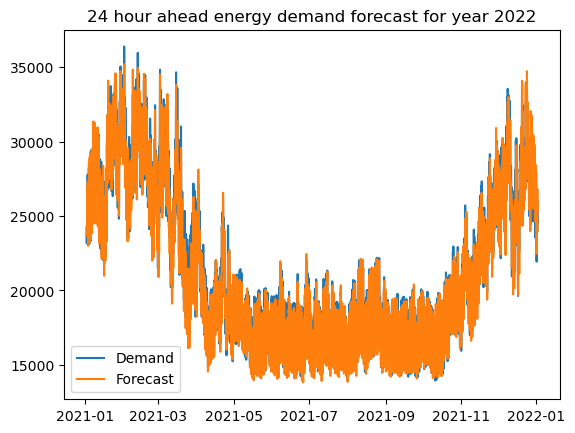

In [4]:
train_start = datetime.datetime(2019, 1, 1, 0, 0, 0)
train_end = datetime.datetime(2020, 12, 31, 23, 0, 0)

# We train the model at each hour increment, for 365 days.
sim = Simulation(365 * 24, train_start, train_end)
forecasts = sim.run_simulation()
sim.plot_sim_results(forecasts)

RMSE
655.4067542963323
MAPE
0.022394927540195727
Percentage within 1000 mwh
0.8781963470319635
Percentage within 500 mwh
0.619406392694064


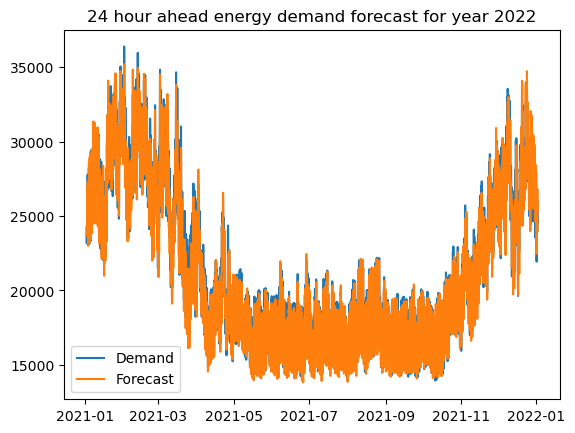

In [5]:
sim.plot_sim_results(forecasts)